Importing all the required libraries

In [0]:
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Fetching the MNIST dataset

In [0]:
mnist = fetch_openml('mnist_784')

splitting the data into test and train and clipping the data to improve the performance

In [0]:
train_data = mnist.data[:60000, :]
test_data = mnist.data[60000:, :]
train_label = mnist.target[:60000]
test_label = mnist.target[60000:]

train_data = np.clip(train_data.reshape(-1, 28*28), 0., 1.)
test_data = np.clip(test_data.reshape(-1, 28*28), 0., 1.)


Constructing the required PCA with appropriate varience level. i.e 90% & 50%

In [0]:
pca = PCA(0.90)
pca.fit(train_data)
compress_train = pca.transform(train_data)
compressed_test = pca.transform(test_data)


train_data_reconstructed = pca.inverse_transform(compress_train)
test_data_reconstructed = pca.inverse_transform(compressed_test)

pca_50 = PCA(0.5)
pca_50.fit(train_data)
compress_train_50 = pca.transform(train_data)
compressed_test_50 = pca.transform(test_data)


train_data_reconstructed_50 = pca.inverse_transform(compress_train)
test_data_reconstructed_50 = pca.inverse_transform(compressed_test)

Reformatting the data into appropriate form and converting them into tensors and creating train loaders

In [0]:
# train data and test data reconstructed converted into torch
train_data_reconstructed=np.array(train_data_reconstructed,dtype="float32")
train_data_reconstructed=torch.from_numpy(train_data_reconstructed)

test_data_reconstructed=np.array(test_data_reconstructed,dtype="float32")
test_data_reconstructed=torch.from_numpy(test_data_reconstructed)

train_data_reconstructed_50=np.array(train_data_reconstructed_50,dtype="float32")
train_data_reconstructed_50=torch.from_numpy(train_data_reconstructed_50)

test_data_reconstructed_50=np.array(test_data_reconstructed_50,dtype="float32")
test_data_reconstructed_50=torch.from_numpy(test_data_reconstructed_50)

train_label=np.array(train_label,dtype="long")
train_label=torch.from_numpy(train_label)
    
test_label=np.array(test_label,dtype="long")
test_label=torch.from_numpy(test_label)

#Scaled test train data converted into torch
train_data=np.array(train_data,dtype="float32")
train_data=torch.from_numpy(train_data)
test_data=np.array(test_data,dtype="float32")
test_data=torch.from_numpy(test_data)

train_data=torch.reshape(train_data,(train_data.shape[0],1,28,28))
test_data=torch.reshape(test_data,(test_data.shape[0],1,28,28))

train_data_reconstructed_50=torch.reshape(train_data_reconstructed_50,(train_data_reconstructed_50.shape[0],1,28,28))
test_data_reconstructed_50=torch.reshape(test_data_reconstructed_50,(test_data_reconstructed_50.shape[0],1,28,28))

train_data_reconstructed=torch.reshape(train_data_reconstructed,(train_data_reconstructed.shape[0],1,28,28))
test_data_reconstructed=torch.reshape(test_data_reconstructed,(test_data_reconstructed.shape[0],1,28,28))

train_loader = torch.utils.data.DataLoader(list(zip(train_data_reconstructed,train_data)), batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(list(zip(test_data_reconstructed,test_data)), batch_size=100, shuffle=False)




Denoising autoencoder.

In [0]:
def denoiser(train_loader):
    losses=[]
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            ## encoder layers ##
            # conv layer (depth from 1 --> 32), 3x3 kernels
            self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
            # conv layer (depth from 32 --> 16), 3x3 kernels
            self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
            # conv layer (depth from 16 --> 8), 3x3 kernels
            self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
            # pooling layer to reduce x-y dims by two; kernel and stride of 2
            self.pool = nn.MaxPool2d(2, 2)
            
            ## decoder layers ##
            # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
            self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
            # two more transpose layers with a kernel of 2
            self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
            self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
            # one, final, normal conv layer to decrease the depth
            self.conv_out = nn.Conv2d(32, 1, 3, padding=1)        

        def forward(self, x):
            ## encode ##
            # add hidden layers with relu activation function
            # and maxpooling after
            x = F.relu(self.conv1(x))
            x = self.pool(x)
            # add second hidden layer
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            # add third hidden layer
            x = F.relu(self.conv3(x))
            x = self.pool(x)  # compressed representation
            
            ## decode ##
            # add transpose conv layers, with relu activation function
            x = F.relu(self.t_conv1(x))
            x = F.relu(self.t_conv2(x))
            x = F.relu(self.t_conv3(x))
            # transpose again, output should have a sigmoid applied
            x = torch.sigmoid(self.conv_out(x))
                    
            return x

    print("Initializing the network ...")
    net = Net()
    net.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001) # lr = learning rate/step size

    ##### Training the network ###################################################
    print("Training the network ...")
    for e in range(10):  # loop over the dataset multiple times
        #print("Epoch: ", e+1)
        train_loss = 0.0
        for data in train_loader:
            inputs, labels = data 
            inputs=inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad() # zero the parameter gradients

            outputs = net(inputs) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backward pass
            optimizer.step() # gradient descent update
            train_loss += loss.item()*inputs.size(0)
            losses.append(loss.item())
            del inputs, outputs, data
            torch.cuda.empty_cache()
        train_loss = train_loss/len(train_loader)
        print("Training loss: "+ str(train_loss))

    
    

    return losses, net

Creating the denoised data from PCA reconstructed data with 90% varience level

In [0]:
def denoised(test_data, train_data, model):
    # model.cpu()
    batchmaker_train = torch.utils.data.DataLoader(train_data, batch_size=1000, shuffle=False)
    denoised_test = model(test_data.cuda())
    denoised_train = torch.Tensor()
    for data in batchmaker_train:
        temp = model(data.cuda())
        temp = temp.detach().cpu()
        denoised_train = torch.cat((denoised_train,temp), 0)
        del temp

    denoised_Test = denoised_test.detach()
    denoised_Train = denoised_train.detach()
    torch.cuda.empty_cache()
    return denoised_Train, denoised_test

Generating the denoised data

In [0]:
def train_denoiser(train_loader, train_data, test_data):
    losses, net = denoiser(train_loader)
    plt.plot(losses)
    plt.show()
    denoised_train, denoised_test = denoised(test_data, train_data, net)
    return denoised_train, denoised_test

Initializing the network ...
Training the network ...
Training loss: 9.851891024659077
Training loss: 6.062742002308369
Training loss: 5.497870312382777
Training loss: 5.086966268097361
Training loss: 4.8158592736969394
Training loss: 4.616252112512787
Training loss: 4.464988419786096
Training loss: 4.343862993642688
Training loss: 4.249506081764896
Training loss: 4.1761176859339075


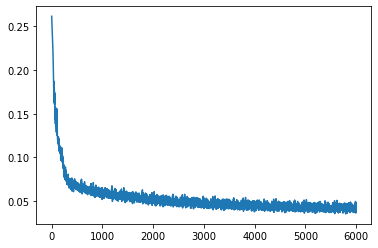

In [14]:
denoised_train, denoised_test = train_denoiser(train_loader, train_data, test_data)

Sample image in denoised test set

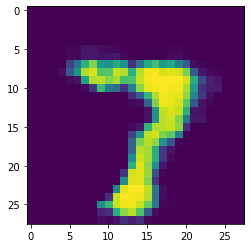

In [15]:
plt.imshow(denoised_test[0].cpu().detach().numpy().reshape(28,28))

Sample image in denoised train set

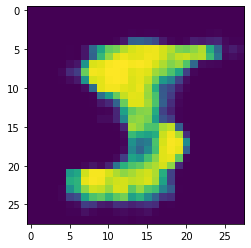

In [16]:
plt.imshow(denoised_train[0].cpu().detach().numpy().reshape(28,28))

Simple CNN to train the images obtained from denoising and PCA reconstruction

In [0]:
def eval_net(epochs, batch_size, train_data, train_label, test_data, test_label):
    train_data_ = list(zip(train_data, train_label))
    test_data_ = list(zip(test_data, test_label))
    ##### Prepare return values ##################################################
    losses = []
    train_acc = 0
    test_acc = 0

    ##### Create iterators for each dataset ######################################
    train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data_, batch_size=batch_size, shuffle=False)

##### Define the network #####################################################
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
            self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
            self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
            self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
            self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
            self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.log_softmax(self.fc3(x), dim=1)
            return x

##### Initialize the network and optimizer ###################################
    print("Initializing the network ...")
    net = Net()
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.001) # lr = learning rate/step size

    ##### Training the network ###################################################
    print("Training the network ...")
    for e in range(epochs):  # loop over the dataset multiple times
        print("Epoch: ", e+1)
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad() # zero the parameter gradients
            train_data_CNN
            outputs = net(inputs) # forward pass
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # backward pass  retain_graph = True
            optimizer.step() # gradient descent update
            losses.append(loss.item())
            del inputs, labels
        
    ##### Evaluating the network on training data ################################
    print("Evaluating on training data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del inputs, labels
        train_acc = correct / total

    #### Evaluating the network on test data ####################################
    print("Evaluating on test data ...")
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del inputs, labels
        test_acc = correct / total

    return losses, train_acc, test_acc

Training the CNN using Denoised data

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9587666666666667
Training accuracy:  0.951


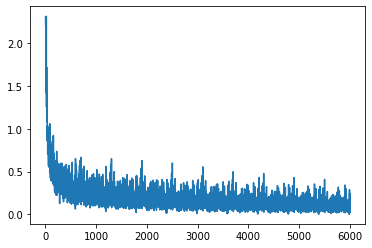

In [133]:
losses, train_acc, test_acc = eval_net(10, 100, denoised_train.detach(), train_label, denoised_test.detach(), test_label)
print("Training accuracy: ", train_acc)
print("Training accuracy: ", test_acc)
plt.plot(losses)
plt.show()

Training the CNN using PCA reconstructed data.

Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.98555
Training accuracy:  0.9801


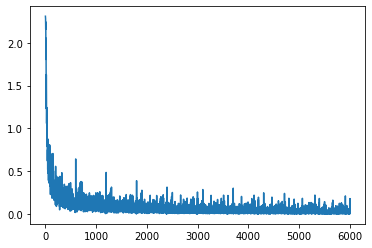

In [136]:
losses, train_acc, test_acc = eval_net(10, 100, train_data_reconstructed_50, train_label, test_data_reconstructed_50, test_label)
print("Training accuracy: ", train_acc)
print("Training accuracy: ", test_acc)
plt.plot(losses)
plt.show()

Comparison: I observed that CNN was able to better perform on reconstructed data than on the denoised data but both of the models were able to obtain a minimum accuracy of 96%.

References:
Autoencoder code used to denoise the data was adapted from github of cezannec: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/denoising-autoencoder/Denoising_Autoencoder_Solution.ipynb